# Imports

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Device Setup

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.is_available()

True

# Image Processing

## Loading Images



In [0]:
# A method to load and transform an image

def image_loader(image_path):

    image = Image.open(image_path)

    # Add a fake batch dimension to fit network's input dimensions
    image = loader(image).unsqueeze(0)

    return image.to(device, torch.float)

In [0]:
# Build an image transformation object

loader = transforms.Compose([
    transforms.Resize((982,256)),  # Scale an image to (982,256)
    transforms.ToTensor()])        # Transform the image into a torch tensor

In [0]:
# The number of styles (or content images) to be used
num_of_styles = 4

# Lists to hold file names of style and content images
style_names = []
content_names = []

image_format = '.jpeg'

# Add file names to the lists
for i in range(num_of_styles):
  style_names.append('style' + str(i+1) + image_format)
  content_names.append('content' + str(i+1) + image_format)

In [0]:
# Lists to hold style and content images
style_images = []
content_images = []

images_directory = 'images/'

# Load images into the lists
for style_name, content_name in zip(style_names, content_names):
  style_images.append(image_loader(images_directory + style_name))
  content_images.append(image_loader(images_directory + content_name))

## Display Images

In [0]:
# A method to display an image

def imshow(tensor, unloader, title=None):

    # Clone the tensor to preserve it
    image = tensor.cpu().clone()

    # Remove the fake batch dimension
    image = image.squeeze(0)

    image = unloader(image)
    plt.imshow(image)

    if title is not None:
        plt.title(title)

    # Pause a bit so that plots are updated
    plt.pause(0.001)

In [0]:
# An image transformation object to convert a tensor into PIL object
unloader = transforms.ToPILImage()

A pair of style and content images:


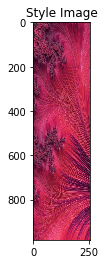

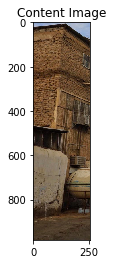


A pair of style and content images:


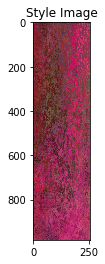

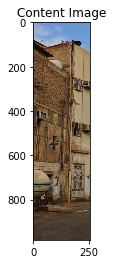


A pair of style and content images:


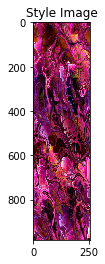

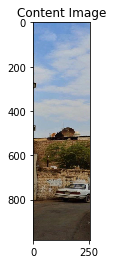


A pair of style and content images:


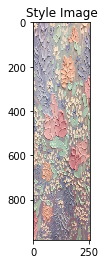

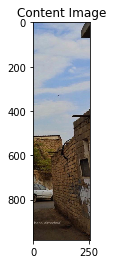

In [69]:
# Display pairs of style and content images

for style_image, content_image in zip(style_images, content_images):

  print("A pair of style and content images:")
  imshow(style_image, unloader, title='Style Image')
  imshow(content_image, unloader, title='Content Image')
  print("")

# Loss Functions



In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## Style Loss




In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Import and Setup a Pre-trained VGG16 Model

In [0]:
cnn = models.vgg16(pretrained=True).features.to(device).eval()

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Input Images

In [0]:
input_images = []

for image in content_images:
  input_images.append(image.clone())

# Training Setup



In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 10 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

# Training



In [0]:
output_images = []

"""
'style_images', 'content_images', and 'input_images' have the same length.

'style_images[i]' corresponds to 'content_images[i]' and 'content_images[i]' 
  corresponds to 'input_images[i]'.
"""

# Train the model 4 different times, and record the 4 output images
for i in range(len(style_images)):
  output_images.append(run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_images[i], style_images[i], input_images[i]))

# Results

## Individual Output Image

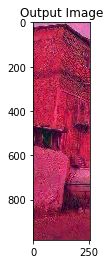

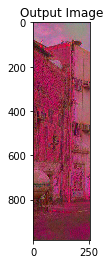

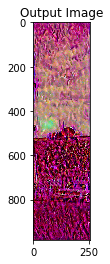

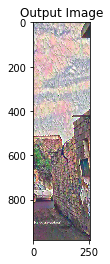

In [77]:
# Display Individual output image

for output_image in output_images:
  
  imshow(output_image, unloader, title='Output Image')
  print("")

## Combined Results

In [0]:
# A method to concatenate several images. It is retrieved from https://note.nkmk.me/en/python-pillow-concat-images/.

def get_concat_h_multi_resize(im_list, resample=Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                      for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst

In [0]:
# Convert output images to PIL objects

PIL_images = []

for output_image in output_images:

  # Copy the tensor to host memory
  output_image = output_image.cpu().clone()

  # Remove the fake batch dimension
  output_image = output_image.squeeze(0)

  # Convert it to PIL object, and add it to 'PIL_images'
  PIL_images.append(unloader(output_image))

In [0]:
# Get the combined output
full_image =  get_concat_h_multi_resize(PIL_images)

# Final Result

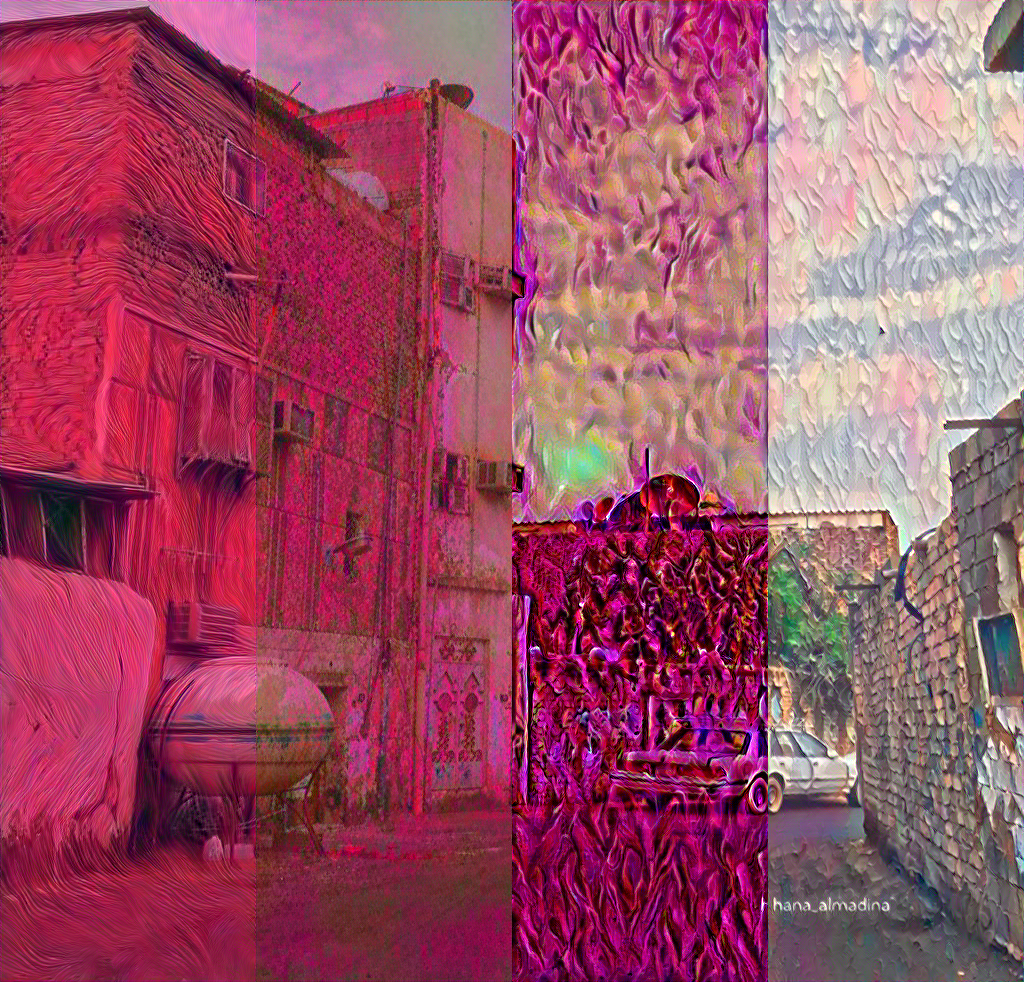

In [81]:
full_image